Import standard libraries to preprocess data

In [1]:
import os
import cv2 # opencv-python package used for image processing resizing, greyscaling and all other operations to prepare the image files to fed in to the model
import numpy as np # linear algebra in the form of arrays and matrix
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm  

import seaborn as sns
import matplotlib.pyplot as plt 

import sklearn
from sklearn.cross_validation import train_test_split

# Data Exploration
Explore the types of breed in the label dataset

In [2]:
lables = pd.read_csv('./data/labels.csv')
lables.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Count the distinct breed we have in the training data

In [3]:
breed_count = lables['breed'].value_counts()
breed_count.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [4]:
breed_count.shape

(120,)

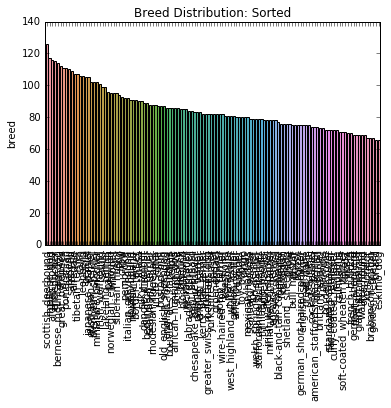

In [5]:
plt.figure()
sns.barplot(x=breed_count.index, y=breed_count)    
plt.xticks(rotation=90)   ## make the labels vertical on x-axis
plt.title('Breed Distribution: Sorted')  #since we have these breed counts sorted while applying value_counts
plt.show(block=False)

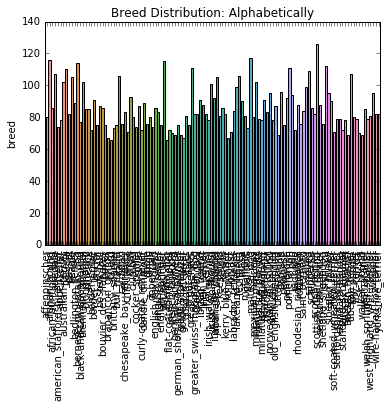

In [6]:
plt.figure()
ind_sorted = breed_count.sort_index()  # sort using index i.e. Aplphabetically we want to plot
sns.barplot(x=ind_sorted.index, y=ind_sorted)
plt.xticks(rotation=90)
plt.title('Breed Distribution: Alphabetically')
plt.show(block=False)

So in total we have 120 breeds in which we have to classify and the distribution of each type of breeds in the given training dataset is of the uniiform type and we cant say there is a class imbalance so we dont have to take care of that also. Since these labels are in the string format we have to one hot encode these labels to identify them as integers

In [7]:
targets = pd.Series(lables['breed'])      
one_hot = pd.get_dummies(targets, sparse = True)
one_hot_labels = np.asarray(one_hot)

# Inspect some dogs
## Let's take a look at some sample images from the training data.

In [8]:
from IPython.display import display, Image

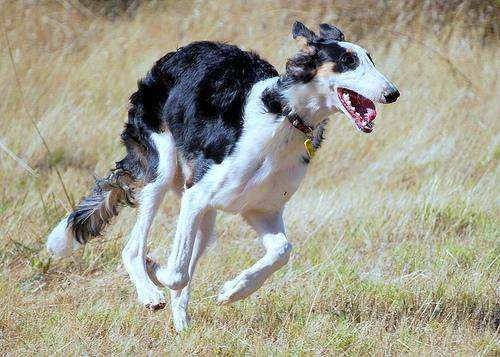

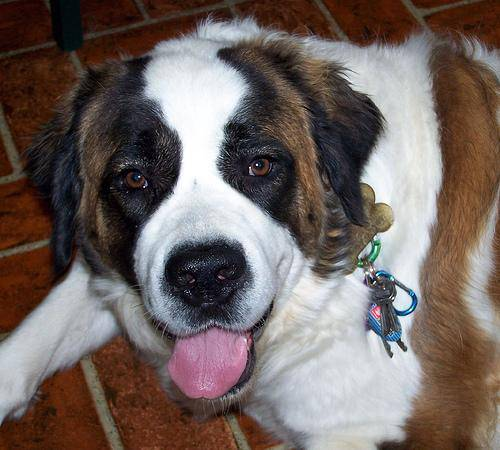

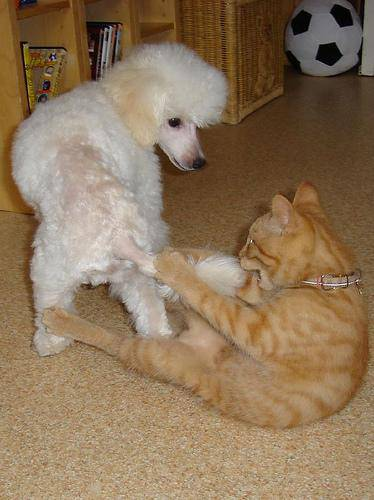

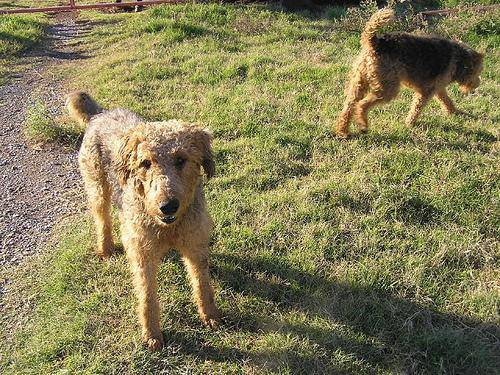

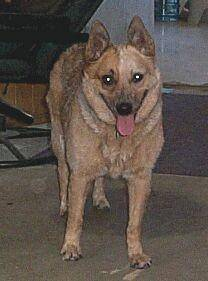

In [10]:
n_train = len(os.listdir('./data/train'))
sample_id = np.random.choice(n_train, 5, replace=False)

for ids in sample_id:
    # Choose a random file from the training data directory.
    fname = os.listdir('./data/train')[ids]
    # Display the image contained in the chosen file.
    image = Image(os.path.join('./data/train', fname))
    display(image)

The images come in many shapes and sizes. This can be problematic for training neural networks, but convolutional neural networks actually handle this quite naturally due to a property they exhibit known as translation invariance; basically, the same feature has equal importance at different points in the input space. However, due to computational considerations (GPUs are more efficient when input data is uniformly sized), we will standardize the input below.

It is noticed that there are some weird examples (perhaps corresponding to outliers, in some statistical sense). For example, I've notice images including dogs and humans or multiple breeds of dog in a single picture. This should be confusing to our neural network model; however, we hope that there are much fewer weird examples than there are typical ones! Even so, these examples may help to regularize the network; that is, allow for better performance on unseen data.

In [11]:
import PIL

In [12]:
#save the widths and heights we have in the training dataset and plot them
widths, heights = [], []

for fname in os.listdir('./data/train'):
    image = PIL.Image.open(os.path.join('./data/train', fname))
    
    # Append image dimensions to list.
    widths.append(image.size[0])  # width
    heights.append(image.size[1])  # height

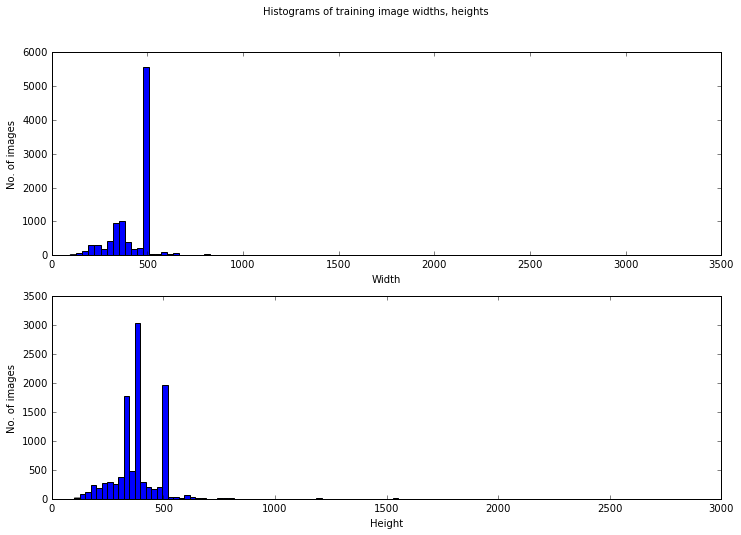

In [13]:
# Plot histograms of heights and widths.
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Histograms of training image widths, heights')

ax1.hist(widths, bins=100); ax1.set_xlabel('Width'); ax1.set_ylabel('No. of images')
ax2.hist(heights, bins=100); ax2.set_xlabel('Height'); ax2.set_ylabel('No. of images')

plt.show()

So like we have did in the MNIST digit classification we have size of image 28 x 28 which is uniform across whole training and test data so we pre-process all the data into equally-sized images, for efficient GPU operation during neural network training.

Also to validate the model performance in each iteration split the training data into training, validation partitions to use for network hyper-parameter tuning).
Lets start with seeing the effect of resizing on single image from training data and then defining a function to read a single image into a numpy.ndarray object. This will read an .jpg image from disk, and resize it into a fixed width and height. We choose a default image size of (256, 256), since it seems reasonable to somewhat downsample the images without losing too much information.One could employ Fourier analysis on the images to confirm that we aren't losing too much high-frequency information in the image data.

In [14]:
n_rows=256
n_cols=256
n_channel=1 #greyscale image

Testing on a single image, first read in the image file in graysalce, then resize it

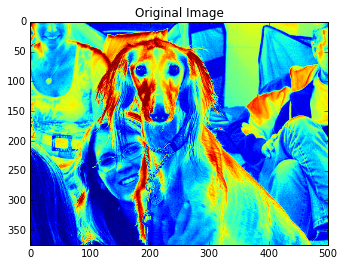

In [15]:
img_sample = cv2.imread('./data/train/2a3b3a4fecb3171df19bed491865c733.jpg', 0) # reading in greyscale mode
plt.title('Original Image')
plt.imshow(img_sample)
plt.show()

(256, 256)


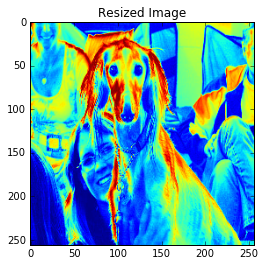

In [16]:
img_sample_resize= cv2.resize(img_sample, (n_rows, n_cols)) 
print (img_sample_resize.shape)
plt.title('Resized Image')
plt.imshow(img_sample_resize)
plt.show()

Now loop the proceedure through the train folder, and keep adding each new image data onto the existing data frame (x_feature)

In [17]:
x_full = []
y_full = []

i = 0 # initialisation
for f, img in tqdm(lables.values): # f for format ,jpg
    train_img = cv2.imread('./data/train/{}.jpg'.format(f),0)
    label = one_hot_labels[i]
    train_img_resize = cv2.resize(train_img, (n_rows, n_cols)) 
    x_full.append(train_img_resize)
    y_full.append(label)
    i += 1

100%|██████████| 10222/10222 [00:17<00:00, 585.93it/s]


The data frames need to be the form of arrays and normolised. Becuase I'm dealing with grayscale here, but in keras we still need to add the dimension

In [18]:
x_data = np.array(x_full, np.float32) / 255.   # /= 255 for normolisation
print (x_data.shape)
x_data = np.expand_dims(x_data, axis = 3)
print (x_data.shape)

(10222, 256, 256)
(10222, 256, 256, 1)


In [19]:
y_data = np.array(y_full, np.uint8)
print (y_data.shape)

(10222, 120)


It is important to create a validation set so that you can gauge the performance of your model on independent data, unseen to the model in training. We do this by splitting the current training set (x_data) and the corresponding labels (y_data) so that we set aside 20 % of the data at random and put these in validation sets (x_val and y_val). I assumed that it contains images from every class, with 120 separate classes.

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2)
print (x_train.shape)
print (x_val.shape)

(8177, 256, 256, 1)
(2045, 256, 256, 1)


After we have done the trainning data, now we are doing the test data, do the same thing to prepare the test data

In [21]:
submission = pd.read_csv('./data/sample_submission.csv')
test = submission['id']
test.head(5)

0    000621fb3cbb32d8935728e48679680e
1    00102ee9d8eb90812350685311fe5890
2    0012a730dfa437f5f3613fb75efcd4ce
3    001510bc8570bbeee98c8d80c8a95ec1
4    001a5f3114548acdefa3d4da05474c2e
Name: id, dtype: object

In [23]:
x_tes = []

i = 0 # initialisation
for f in tqdm(test.values): # f for format ,jpg
    img = cv2.imread('./data/test/{}.jpg'.format(f), 0)
    img_resize = cv2.resize(img, (n_rows, n_cols)) 
    x_tes.append(img_resize)

100%|██████████| 10357/10357 [00:22<00:00, 453.41it/s]


In [24]:
x_test = np.array(x_tes, np.float32) / 255. 
print (x_test.shape)
x_test = np.expand_dims(x_test, axis = 3)
print (x_test.shape)

(10357, 256, 256)
(10357, 256, 256, 1)


Now we have prepared: x_train, y_train, x_val, y_val and x_test. Time to build our CNN model. First import keras

In [25]:
from keras.models import Sequential  
from keras.layers import Dense, Dropout 
from keras.layers import Convolution2D 
from keras.layers import MaxPooling2D 
from keras.layers import Flatten

Using TensorFlow backend.


Just try simple CNN here

1. Convetional layer (detect features in image matrix)
2. Pooling layer (recongise features in different angle and/or size)
3. Convetional layer
4. Pooling layer
5. Convetional layer
6. Pooling layer
7. Flattening layer (flatten layers in array of imput)
8. Full connected layer (full connected ANN)
9. Output layer

In [27]:
model = Sequential()
# retifier ensure the non-linearity in the processing 
model.add(Convolution2D (filters = 64, kernel_size = (4,4),padding = 'Same', 
                         activation ='relu', input_shape = (n_rows, n_cols, n_channel))) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D (filters = 64, kernel_size = (4,4),padding = 'Same', 
                         activation ='relu')) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D (filters = 64, kernel_size = (4,4),padding = 'Same', 
                         activation ='relu')) 
#model.add(MaxPooling2D(pool_size=(2,2))) ---- Model 1
#model.add(Flatten()) 
# fully connected ANN 
model.add(Dense(units = 120, activation = 'relu')) 
# output layer
model.add(Dense(units = 120, activation = 'softmax')) 
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"]) 

In [ ]:
batch_size = 128 
epochs = 2
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val, y_val),initial_epoch=0)

Train on 8177 samples, validate on 2045 samples
Epoch 1/2


Saving the results in the submission format. 

/usr/local/lib/python3.4/dist-packages/matplotlib/artist.py:210: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


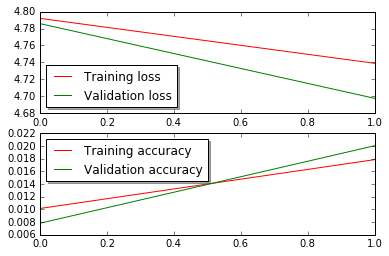

In [26]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='r', label="Training loss")
ax[0].plot(history.history['val_loss'], color='g', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='r', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='g',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

In [27]:
results = model.predict(x_test)
prediction = pd.DataFrame(results)

# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
prediction.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
prediction.insert(0, 'id', submission['id'])

submission = prediction
submission.to_csv('submission.csv', index=False)